Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 36.3MB/s]



=== Start α=100.0 | K=5 | R=50 ===
Client sizes (min/median/max): 4910/5008.0/5207 (sum=50000)
  Round  1/50 | Acc  55.52% | Drift 0.7202 | Time 54.24s
  Round  2/50 | Acc  61.73% | Drift 0.7604 | Time 53.57s
  Round  3/50 | Acc  65.66% | Drift 0.6530 | Time 53.94s
  Round  4/50 | Acc  66.99% | Drift 0.5294 | Time 54.45s
  Round  5/50 | Acc  68.24% | Drift 0.4572 | Time 54.53s
  Round  6/50 | Acc  68.82% | Drift 0.4245 | Time 54.30s
  Round  7/50 | Acc  69.23% | Drift 0.3989 | Time 54.47s
  Round  8/50 | Acc  69.30% | Drift 0.3844 | Time 54.32s
  Round  9/50 | Acc  69.92% | Drift 0.3608 | Time 54.29s
  Round 10/50 | Acc  69.85% | Drift 0.3433 | Time 53.88s
  Round 11/50 | Acc  70.02% | Drift 0.3371 | Time 54.03s
  Round 12/50 | Acc  70.16% | Drift 0.3284 | Time 54.53s
  Round 13/50 | Acc  69.97% | Drift 0.3352 | Time 54.26s
  Round 14/50 | Acc  70.19% | Drift 0.3139 | Time 54.12s
  Round 15/50 | Acc  69.97% | Drift 0.3184 | Time 54.76s
  Round 16/50 | Acc  70.01% | Drift 0.2984 | Time

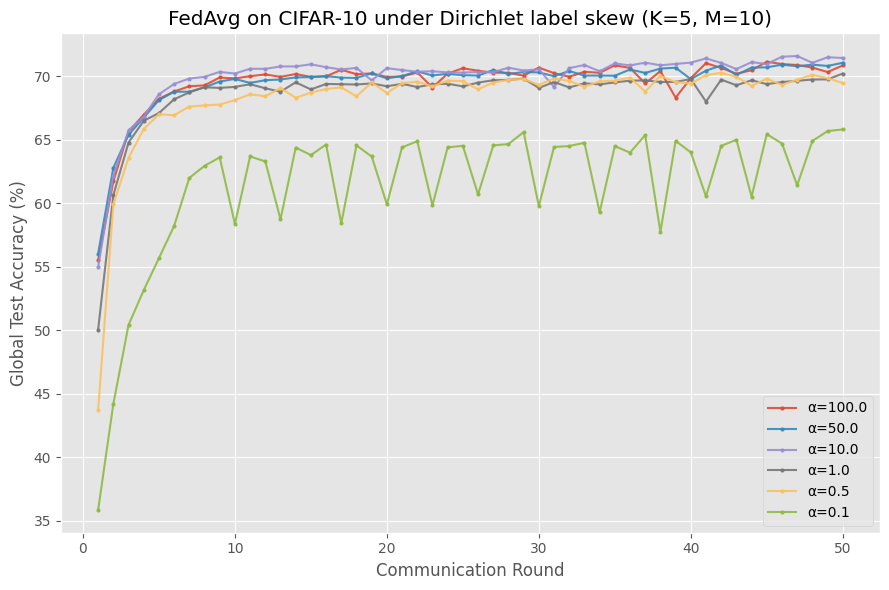

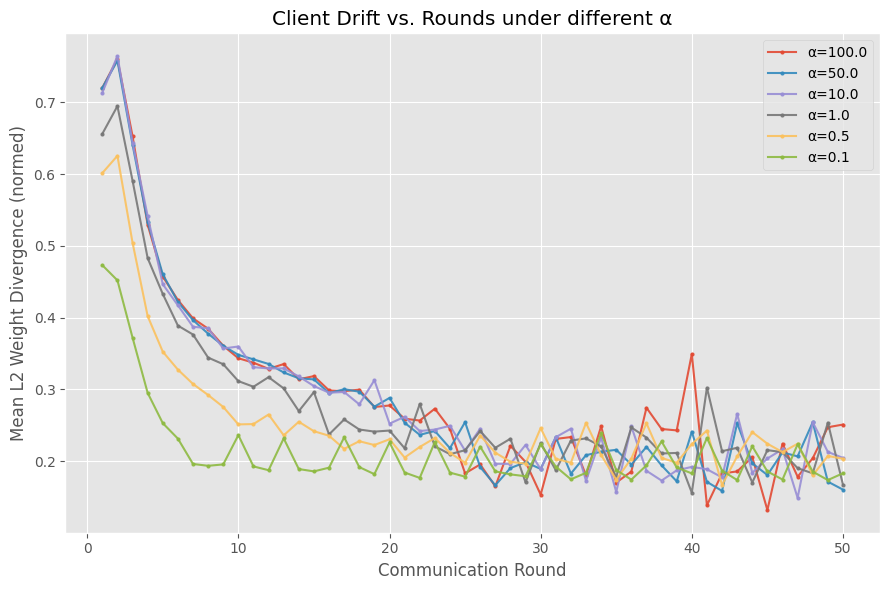

In [1]:
# ==== Task 3: FedAvg under Dirichlet label skew (clean, merged scaffold) ====

import os, copy, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# ----- 0) Repro & device -----
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

NUM_CLIENTS = 10
TOTAL_TRAIN_SAMPLES = 50000
SAMPLES_PER_CLIENT = TOTAL_TRAIN_SAMPLES // NUM_CLIENTS
LEARNING_RATE = 0.01
NUM_ROUNDS = 50
LOCAL_BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Task 3 settings (your values)
K_VALUE = 5
CLIENT_FRACTION = 1.0  # full participation for clarity
ALPHAS = [100.0, 50.0, 10.0, 1.0, 0.5, 0.1]  # you can slim to [100, 1, 0.2, 0.05] later

# ----- 1) Model -----
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def save_weights(model: nn.Module, path: str = "CNN_weights/init_weights.pt") -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def load_weights(model: nn.Module, path: str = "CNN_weights/init_weights.pt", map_location=None) -> None:
    state_dict = torch.load(path, map_location=map_location)
    model.load_state_dict(state_dict)

# ----- 2) Data -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset       = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

train_labels = np.array(full_train_dataset.targets)  # labels for partitioning

def dirichlet_partition(labels, num_clients, alpha, seed=42):
    """Return list of per-client index arrays split by class using Dir(alpha)."""
    rng = np.random.default_rng(seed)
    labels = np.array(labels)
    client_indices = [[] for _ in range(num_clients)]
    for c in np.unique(labels):
        idx_c = np.where(labels == c)[0]
        rng.shuffle(idx_c)
        p = rng.dirichlet(np.full(num_clients, alpha))
        counts = (p * len(idx_c)).astype(int)
        counts[-1] += len(idx_c) - counts.sum()  # fix rounding
        start = 0
        for j in range(num_clients):
            take = counts[j]
            if take > 0:
                client_indices[j].extend(idx_c[start:start+take].tolist())
            start += take
    return [np.array(sorted(ix)) for ix in client_indices]

def build_client_loaders_dirichlet(alpha):
    """Build DataLoaders and sizes for a given alpha partition."""
    client_idxs = dirichlet_partition(train_labels, NUM_CLIENTS, alpha, seed=42)
    loaders, sizes = [], []
    for idx in client_idxs:
        ds = Subset(full_train_dataset, idx.tolist())
        loaders.append(DataLoader(ds, batch_size=LOCAL_BATCH_SIZE, shuffle=True, num_workers=2))
        sizes.append(len(idx))
    return loaders, sizes

# ----- 3) FL helpers -----
def client_update(model_state, client_loader, k_epochs, lr):
    """K local epochs of SGD on one client, returns new state_dict."""
    model = SimpleCNN().to(DEVICE)
    model.load_state_dict(model_state)
    model.train()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    for _ in range(k_epochs):
        for images, labels in client_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

def server_aggregate_weighted(client_models, client_sizes):
    """Standard FedAvg weighted by local data sizes."""
    keys = client_models[0].keys()
    N = float(sum(client_sizes))
    new_global = {}
    for k in keys:
        # start with a zeros tensor on the same device as first tensor
        agg = torch.zeros_like(client_models[0][k])
        for state, n_i in zip(client_models, client_sizes):
            agg = agg + state[k] * (n_i / N)
        new_global[k] = agg
    return new_global

def l2_divergence(global_w, client_w_list):
    """Mean ||w_i - w||_2 / ||w||_2 across clients, computed on CPU tensors."""
    with torch.no_grad():
        gw = torch.cat([p.detach().cpu().flatten() for p in global_w.values()])
        gw_norm = gw.norm() + 1e-12
        divs = []
        for cw in client_w_list:
            cwv = torch.cat([p.detach().cpu().flatten() for p in cw.values()])
            divs.append((cwv - gw).norm() / gw_norm)
        return float(torch.mean(torch.stack(divs)))

def evaluate_model(model, test_loader):
    model.to(DEVICE)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100.0 * correct / total
    avg_loss = total_loss / len(test_loader)
    return acc, avg_loss

# ----- 4) One-time init weights (reused across α runs) -----
_init_model = SimpleCNN().to(DEVICE)
INITIAL_STATE = copy.deepcopy(_init_model.state_dict())

# ----- 5) α-runner -----
def run_fedavg_alpha(alpha, k_epochs, num_rounds, initial_state_dict):
    print(f"\n=== Start α={alpha} | K={k_epochs} | R={num_rounds} ===")
    global_model = SimpleCNN().to(DEVICE)
    global_model.load_state_dict(copy.deepcopy(initial_state_dict))

    client_loaders, client_sizes = build_client_loaders_dirichlet(alpha)
    # quick inspect to ensure non-empty splits
    sz = np.array(client_sizes)
    print(f"Client sizes (min/median/max): {sz.min()}/{np.median(sz)}/{sz.max()} (sum={sz.sum()})")

    acc_hist, drift_hist = [], []
    for r in range(num_rounds):
        t0 = time.time()
        global_w = copy.deepcopy(global_model.state_dict())

        # full participation
        client_updates = []
        for j in range(NUM_CLIENTS):
            local_state = client_update(copy.deepcopy(global_w), client_loaders[j], k_epochs, LEARNING_RATE)
            client_updates.append(local_state)

        drift = l2_divergence(global_w, client_updates)
        drift_hist.append(drift)

        new_global = server_aggregate_weighted(client_updates, client_sizes)
        global_model.load_state_dict(new_global)

        acc, loss = evaluate_model(global_model, test_loader)
        acc_hist.append(acc)

        print(f"  Round {r+1:2d}/{num_rounds} | Acc {acc:6.2f}% | Drift {drift:.4f} | Time {time.time()-t0:.2f}s")
    return acc_hist, drift_hist

# ----- 6) Run experiments over α -----
results_acc, results_drift = {}, {}
for a in ALPHAS:
    acc_hist, drift_hist = run_fedavg_alpha(a, K_VALUE, NUM_ROUNDS, INITIAL_STATE)
    results_acc[f"α={a}"] = acc_hist
    results_drift[f"α={a}"] = drift_hist

print("\nAll α runs complete.")

# ----- 7) Plots -----
plt.style.use('ggplot')
rounds = list(range(1, NUM_ROUNDS + 1))

# Accuracy plot
plt.figure(figsize=(9,6))
for label, hist in results_acc.items():
    plt.plot(rounds, hist, marker='o', markersize=2, alpha=0.9, label=label)
plt.xlabel('Communication Round')
plt.ylabel('Global Test Accuracy (%)')
plt.title(f'FedAvg on CIFAR-10 under Dirichlet label skew (K={K_VALUE}, M={NUM_CLIENTS})')
plt.legend()
plt.tight_layout()
plt.savefig('fedavg_dirichlet_acc.png')
print("Saved: fedavg_dirichlet_acc.png")

# Drift plot
plt.figure(figsize=(9,6))
for label, hist in results_drift.items():
    plt.plot(rounds, hist, marker='o', markersize=2, alpha=0.9, label=label)
plt.xlabel('Communication Round')
plt.ylabel('Mean L2 Weight Divergence (normed)')
plt.title('Client Drift vs. Rounds under different α')
plt.legend()
plt.tight_layout()
plt.savefig('fedavg_dirichlet_drift.png')
print("Saved: fedavg_dirichlet_drift.png")
